# Make a gender, age and ethnicity guesser based on webcam

In [ ]:
# Import libraries

In [1]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# upload file and unzip it contents and create a df

In [3]:
from google.colab import files
uploaded = files.upload()

Saving age_gender.csv.zip to age_gender.csv.zip


In [4]:
!unzip /content/age_gender.csv.zip

Archive:  /content/age_gender.csv.zip
  inflating: age_gender.csv          


In [5]:
dataframe = "/content/age_gender.csv"
df = pd.read_csv(dataframe)
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
# count pixels and and square root to see shape 48x48

In [6]:
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [7]:
# Converting list to numpay array since we are using csv file
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))


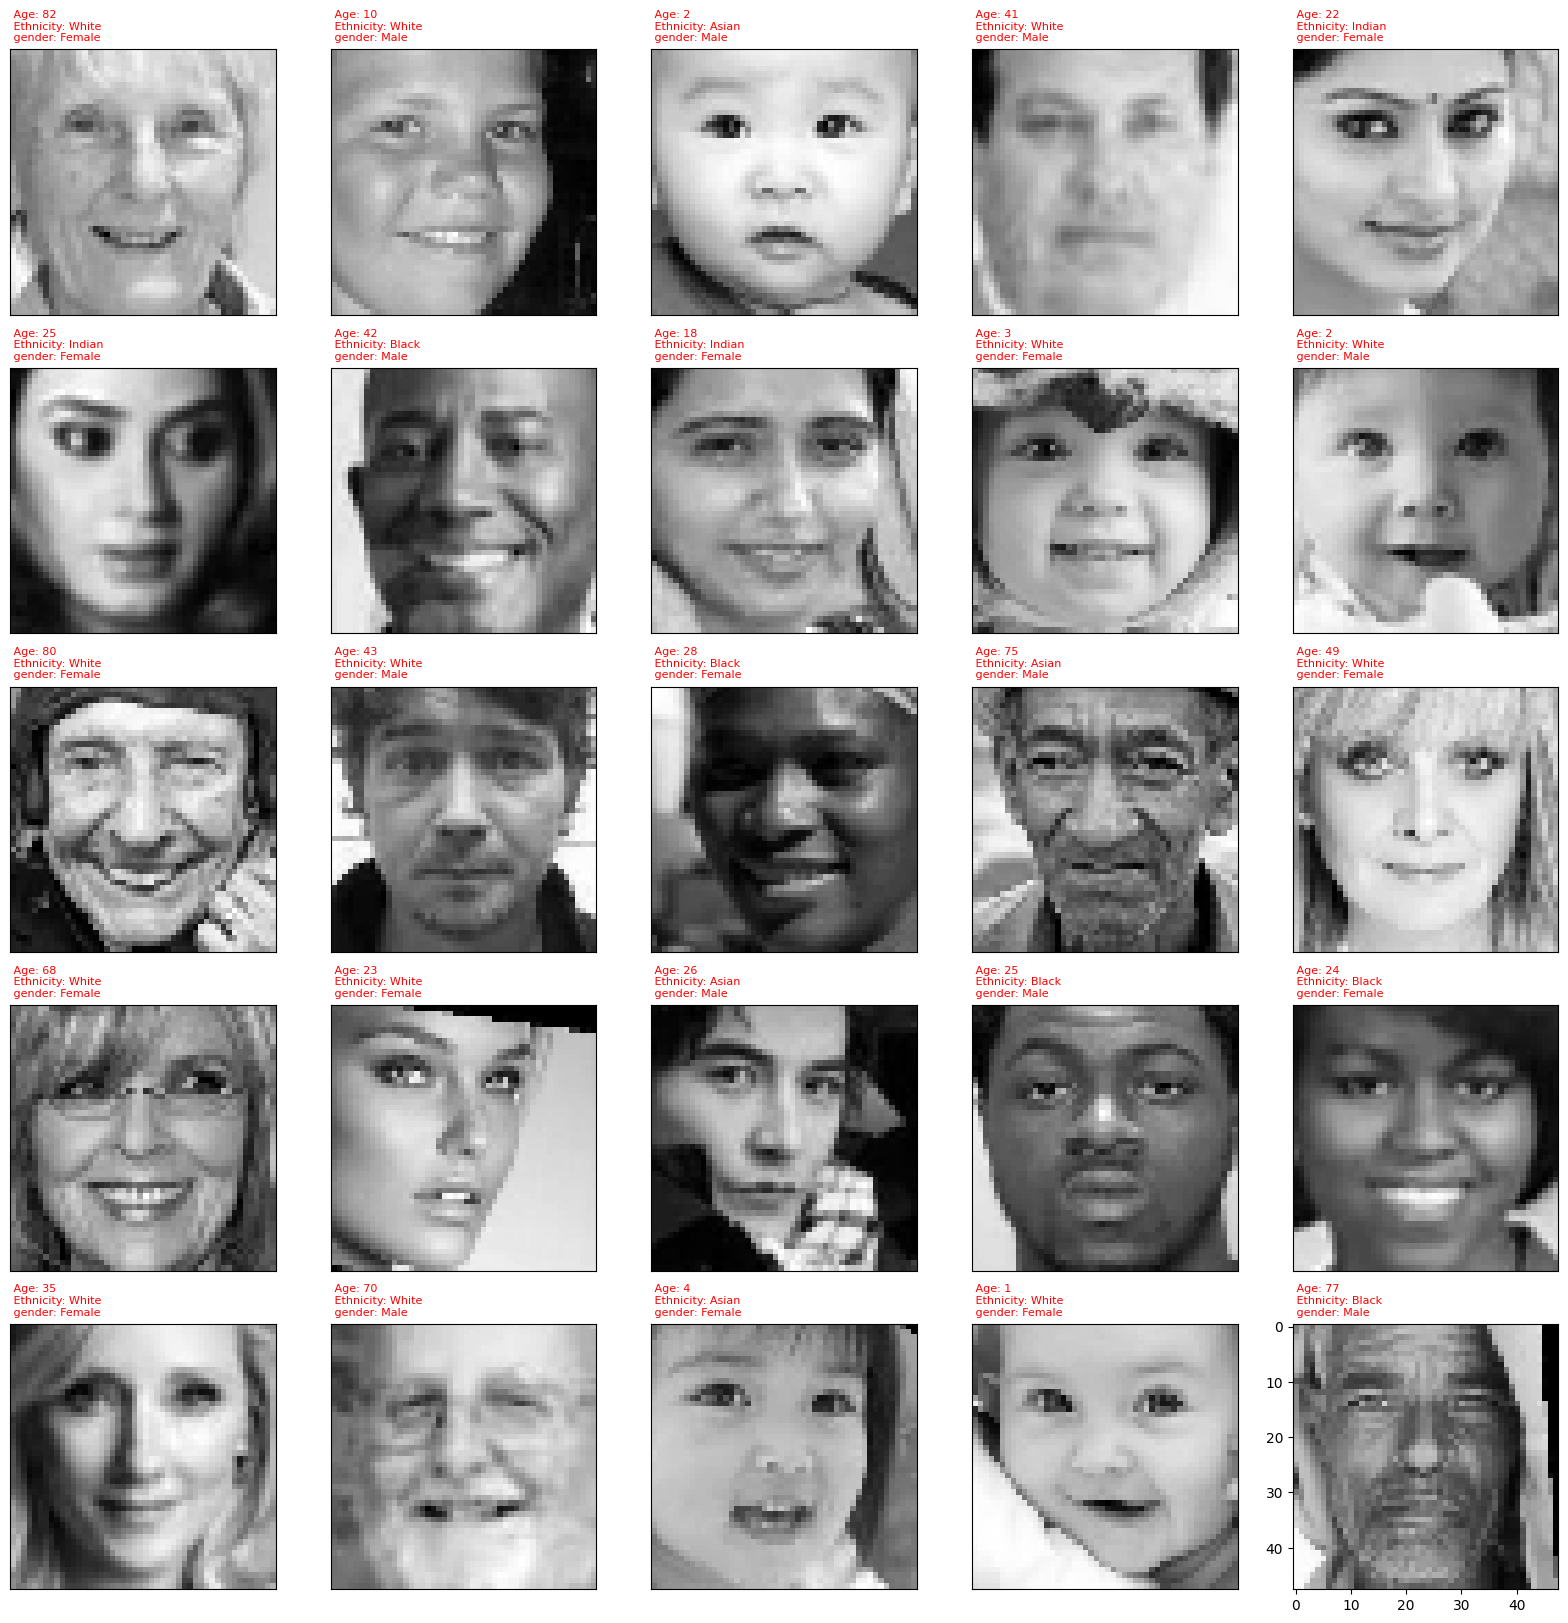

In [8]:
# Plot
plt.figure(figsize=(20, 20))

for i in range(25):
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

In [ ]:
# Standardize pictures to 48x48 and start processing for age

In [9]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))
y = df['age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=44)

In [10]:
# Original code for data augmentation only included rescale.
# Added the rest for better accuracy and hopefully solve issue with only guessing male - solved issue

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator_age=train_datagen.flow(
    X_train_age ,y_train_age ,batch_size=64
)

test_datagen=ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_generator_age=test_datagen.flow(
    X_test_age ,y_test_age ,batch_size=64
)


In [ ]:
# Early stopping and learning rate to prevent overfitting
# Added checkpoint to be able to save best model

In [12]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [41]:
# Create checkpoint, earlystop and lrr for age model
# looking at val mean avsolute error so mode is min
checkpoint_path = "age_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_mean_absolute_error',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_mean_absolute_error',
    patience= 3,
    verbose=1,
)

callbacks = [earlystop, checkpoint, learning_rate_reduction]

In [ ]:
## Got error after trying to build checkpoint for age_model
# Changed monitor to 'val_mean_absolute_error' instead and fixed the issue

In [ ]:
# Build 3 different models, one for age one for gender and one for ethnicity

In [ ]:
# Building a sequential model for age
# added batchnormalization, change last activation from relu to linear
# removed batchnormalization. Age got 20 years extra after this change, gonna make another try with linear as last activation
# still worse results with linear as last optimizer so went back to relu.
# doing another try with batchnormalization and relu to se if i can improve the model
# With batch normalization age was still 10 years older
# Conclusion simpler model is better with age, also seems like glasses adds 5 years
# Seems like white hair adds about 20-30 years as well

In [42]:
model_age = Sequential()

# 1st CNN layer
model_age.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_age.add(MaxPooling2D(2,2))

# 2nd CNN layer
model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))

# 3rd CNN layer with dropout
model_age.add(Conv2D(64,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))

# 4th CNN layer
model_age.add(Conv2D(128,(3,3),activation='relu'))
model_age.add(MaxPooling2D(2,2))
model_age.add(Dropout(0.2))

# Flatten
model_age.add(Flatten())
model_age.add(Dropout(0.5))

#
model_age.add(Dense(1,activation='relu'))

# model_age.compile(optimizer='adam' ,loss='mean_squared_error',metrics=['mae'])
model_age.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
model_age.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 4, 4, 64)         

In [ ]:
# Fit the model
model_age.fit(
    train_generator_age,
    epochs= 48,
    validation_data= test_generator_age,
    callbacks= callbacks
)

Epoch 1/48
259/260 [============================>.] - ETA: 0s - loss: 482.9469 - mean_absolute_error: 16.9293
Epoch 1: val_mean_absolute_error improved from inf to 14.65974, saving model to age_model.h5
260/260 [==============================] - 14s 49ms/step - loss: 482.6313 - mean_absolute_error: 16.9215 - val_loss: 373.9161 - val_mean_absolute_error: 14.6597 - lr: 0.0010
Epoch 2/48
259/260 [============================>.] - ETA: 0s - loss: 398.0737 - mean_absolute_error: 15.3037
Epoch 2: val_mean_absolute_error improved from 14.65974 to 14.43979, saving model to age_model.h5
260/260 [==============================] - 15s 59ms/step - loss: 398.5234 - mean_absolute_error: 15.3176 - val_loss: 360.5968 - val_mean_absolute_error: 14.4398 - lr: 0.0010
Epoch 3/48
259/260 [============================>.] - ETA: 0s - loss: 396.3074 - mean_absolute_error: 15.2958
Epoch 3: val_mean_absolute_error improved from 14.43979 to 14.28050, saving model to age_model.h5
260/260 [========================

<Axes: title={'center': 'Age'}>

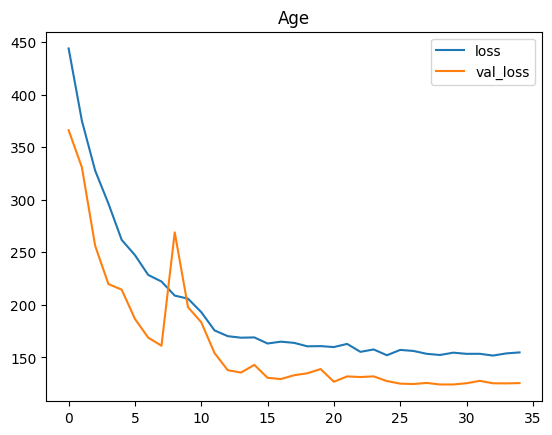

In [ ]:
# Plot
losses_age = pd.DataFrame(model_age.history.history)
losses_age[['loss','val_loss']].plot(title='Age')

In [ ]:
# Ethnicity, splitting data in train and test

In [25]:
y = df['ethnicity']
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
train_generator_ethnicity =train_datagen.flow(
    X_train_ethnicity ,y_train_ethnicity ,batch_size=64
)

test_generator_ethnicity =test_datagen.flow(
    X_test_ethnicity ,y_test_ethnicity ,batch_size=64
)

In [ ]:
# Model for ethnicity
# using sparse_categorical since 0-4 format.
# metrics as val acc
# Changed metrics to sparse_categorical_accuracy because of errors.
# added batchnormalziation

In [27]:
model_ethnicity = Sequential()

# 1st cnn layer
model_ethnicity.add(Conv2D(16,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2,2))

# 2nd cnn layer
model_ethnicity.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2,2))

# 3rd cnn layer
model_ethnicity.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPooling2D(2,2))

# Flatten
model_ethnicity.add(Flatten())

# Fully connected first layer
model_ethnicity.add(Dense(128,activation='relu'))

# Fully connected second layer
model_ethnicity.add(Dense(5,activation='softmax'))

model_ethnicity.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

model_ethnicity.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 batch_normalization_11 (Ba  (None, 24, 24, 32)        128       
 tchNormalization)                                               
                                                      

In [30]:
# Create checkpoint, earlystop and lrr for ethnicity
# Changed checkpoint to monitor val_sparse_cat_acc to be able to save the model.
# Looking and val sparse cat acc so mode = max
checkpoint_path = "ethnicity_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor= 'val_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    patience= 3,
    verbose=1,
)

callbacks_et = [earlystop, checkpoint, learning_rate_reduction]

In [31]:
# Fit model

In [32]:
model_ethnicity.fit(
    train_generator_ethnicity,
    epochs= 48,
    validation_data= test_generator_ethnicity,
    callbacks= callbacks_et
)

Epoch 1/48
259/260 [============================>.] - ETA: 0s - loss: 1.1078 - sparse_categorical_accuracy: 0.5797
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.53178, saving model to ethnicity_model.h5
260/260 [==============================] - 10s 39ms/step - loss: 1.1074 - sparse_categorical_accuracy: 0.5797 - val_loss: 1.4994 - val_sparse_categorical_accuracy: 0.5318 - lr: 0.0010
Epoch 2/48
259/260 [============================>.] - ETA: 0s - loss: 1.0240 - sparse_categorical_accuracy: 0.6208
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.53178
260/260 [==============================] - 11s 43ms/step - loss: 1.0241 - sparse_categorical_accuracy: 0.6208 - val_loss: 1.3240 - val_sparse_categorical_accuracy: 0.4613 - lr: 0.0010
Epoch 3/48
260/260 [==============================] - ETA: 0s - loss: 0.9721 - sparse_categorical_accuracy: 0.6444
Epoch 3: val_sparse_categorical_accuracy improved from 0.53178 to 0.61277, saving model to ethnicity_model.h5


In [ ]:
# Plotting

In [ ]:
losses_ethnicity = pd.DataFrame(model_ethnicity.history.history)
losses_ethnicity[['accuracy','val_accuracy']].plot(title='Ethnicity')
losses_ethnicity[['loss','val_loss']].plot(title='Ethnicity')

In [ ]:
# Create sets for gender
#

In [13]:
y = df['gender']
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, y, test_size=0.3, random_state=44)

In [14]:
train_generator_gender =train_datagen.flow(
    X_train_gender ,y_train_gender ,batch_size=64
)

test_generator_gender =test_datagen.flow(
    X_test_gender ,y_test_gender ,batch_size=64
)

In [ ]:
# Add checkpoint for model_gender so we can save best one
# Looking at val accuracy and mode max

In [18]:
checkpoint_path = "gender_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor= 'val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience= 3,
    verbose=1,
)

callbacks_gender = [earlystop, checkpoint, learning_rate_reduction]

In [ ]:
# Model for gender.
# Added batchnormalization and dropout
# Changed optimizer to adam from SGD

In [19]:
model_gender = Sequential()

# 1st cnn layer
model_gender.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPooling2D(2,2))
model_gender.add(Dropout(0.25))

# 2nd cnn layer
model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(BatchNormalization())
model_gender.add(MaxPooling2D(2,2))
model_gender.add(Dropout(0.25))

# 3rd cnn layer
model_gender.add(Conv2D(64,(3,3),activation='relu'))
model_gender.add(BatchNormalization())
model_gender.add(MaxPooling2D(2,2))
model_gender.add(Dropout(0.25))

# Flatten
model_gender.add(Flatten())

# connected layer with sigmoid since binary classification
model_gender.add(Dense(1,activation='sigmoid'))

model_gender.compile(optimizer='adam' ,loss='BinaryCrossentropy',metrics=['accuracy'])

model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 21, 21, 64)       

In [20]:
# Fit model
model_gender.fit(
    train_generator_gender,
    epochs= 48,
    validation_data= test_generator_gender,
    callbacks= callbacks_gender
)

Epoch 1/48
259/260 [============================>.] - ETA: 0s - loss: 0.7875 - accuracy: 0.5999
Epoch 1: val_accuracy improved from -inf to 0.53726, saving model to gender_model.h5
260/260 [==============================] - 14s 47ms/step - loss: 0.7879 - accuracy: 0.5994 - val_loss: 0.6765 - val_accuracy: 0.5373 - lr: 0.0100
Epoch 2/48
260/260 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.6243
Epoch 2: val_accuracy improved from 0.53726 to 0.67478, saving model to gender_model.h5
260/260 [==============================] - 16s 63ms/step - loss: 0.6865 - accuracy: 0.6243 - val_loss: 0.6191 - val_accuracy: 0.6748 - lr: 0.0100
Epoch 3/48
260/260 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.6286
Epoch 3: val_accuracy did not improve from 0.67478
260/260 [==============================] - 16s 61ms/step - loss: 0.6686 - accuracy: 0.6286 - val_loss: 0.6138 - val_accuracy: 0.6651 - lr: 0.0100
Epoch 4/48
260/260 [==============================

In [ ]:
# Added droupout and batchnormalization to see if i can improve the model
# Seems like having long hair and having your hair out weights a lot when it comes to gender.

<Axes: title={'center': 'Gender'}>

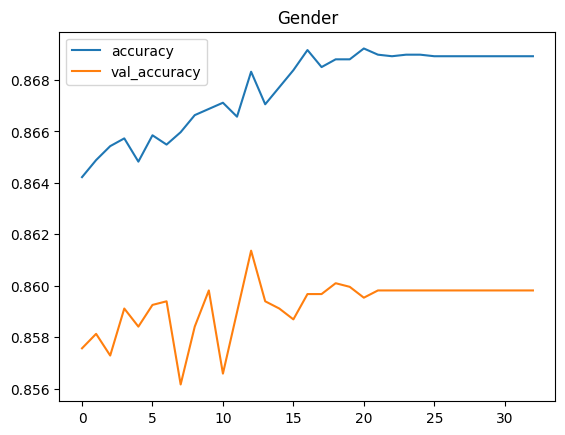

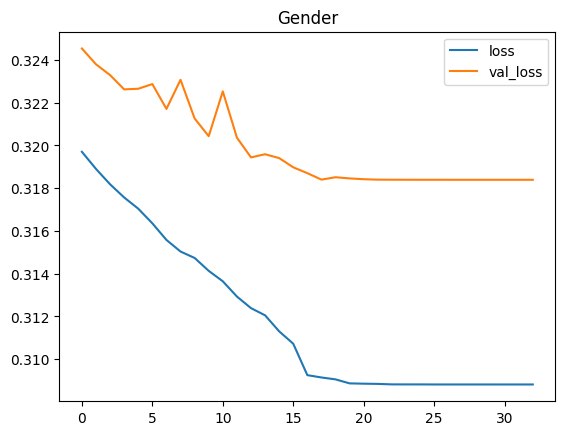

In [ ]:
losses_gender = pd.DataFrame(model_gender.history.history)
losses_gender[['accuracy','val_accuracy']].plot(title='Gender')
losses_gender[['loss','val_loss']].plot(title='Gender')